In [159]:
import jsonpickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.ndimage import gaussian_filter
from scipy.stats import weibull_min, t
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from scipy.stats import skewnorm
from utils import read_log

# Plotting PnL

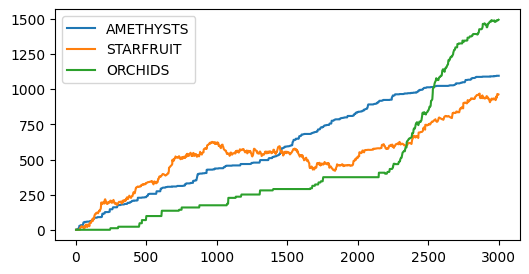

In [2]:
loaded = pd.read_csv('data/2/run.csv', delimiter=';')
plt.figure(figsize=(6, 3))
plt.plot(loaded[loaded['product'] == 'AMETHYSTS']['profit_and_loss'], label='AMETHYSTS')
plt.plot(loaded[loaded['product'] == 'STARFRUIT']['profit_and_loss'], label='STARFRUIT')
plt.plot(loaded[loaded['product'] == 'ORCHIDS']['profit_and_loss'], label='ORCHIDS')
plt.legend()
plt.show()

# Loading data from logs

In [3]:
PATH = 'logs/round_2/1.log'
sandbox, activities, trade_history = read_log(PATH)

In [4]:
south_data = []
for itm in sandbox['lambdaLog']:
    try:
        south_data.append(jsonpickle.decode(itm))
    except:
        pass
south_data = pd.DataFrame.from_dict(south_data)
south_data.head()

,bid_price,ask_price,transport_fees,export_tariff,import_tariff,sunlight,humidity
0,1097.5,1099.0,0.9,10.5,-5.0,2100.0000,70.000000
1,1097.5,1099.0,0.9,9.5,-5.0,2099.7570,70.022710
2,1096.0,1097.5,0.9,9.5,-5.0,2099.5132,70.045395
3,1096.0,1098.0,0.9,9.5,-5.0,2099.2683,70.068030
4,1096.5,1098.0,0.9,9.5,-5.0,2099.0225,70.090640


In [5]:
(south_data['ask_price'] - south_data['bid_price']).unique()

array([1.5, 2. ])

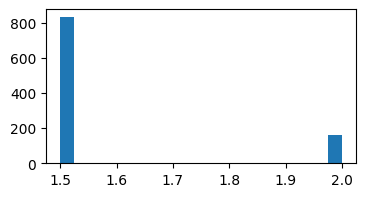

In [6]:
plt.figure(figsize=(4, 2))
plt.hist(south_data['ask_price'] - south_data['bid_price'], bins=20)
plt.show()

In [7]:
north_data = activities[activities['product'] == 'ORCHIDS'].drop(columns=['day', 'product', 'profit_and_loss', 'timestamp']).reset_index(drop=True)
north_data.head()

,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price
0,1094,10,1093.0,3.0,1086.0,41.0,1102,10,1104.0,3.0,1111.0,41.0,1098.0
1,1094,6,1093.0,2.0,1087.0,51.0,1102,6,1103.0,2.0,1110.0,51.0,1098.0
2,1093,6,1092.0,3.0,1085.0,49.0,1101,6,1102.0,3.0,1108.0,49.0,1097.0
3,1093,10,1092.0,4.0,1085.0,52.0,1101,10,1102.0,4.0,1109.0,52.0,1097.0
4,1093,10,1092.0,3.0,1086.0,51.0,1101,10,1102.0,3.0,1109.0,51.0,1097.0


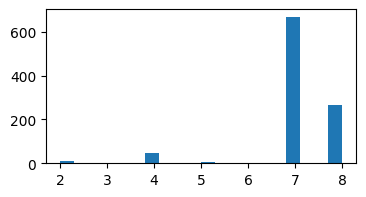

In [8]:
spread = north_data['ask_price_1'] - north_data['bid_price_1']

plt.figure(figsize=(4, 2))
plt.hist(spread, bins=20)
plt.show()

# Load provided data

In [9]:
prices_1 = pd.read_csv('data/2/prices_round_2_day_-1.csv', delimiter=';').drop(columns=['DAY']).set_index('timestamp', drop=True)
prices_2 = pd.read_csv('data/2/prices_round_2_day_0.csv', delimiter=';').drop(columns=['DAY']).set_index('timestamp', drop=True)
prices_3 = pd.read_csv('data/2/prices_round_2_day_1.csv', delimiter=';').drop(columns=['DAY']).set_index('timestamp', drop=True)

In [10]:
rand_half_spreads = np.random.choice(spread, prices_1.shape[0]) / 2
prices_1 = prices_1.assign(bid_price=lambda x: x.ORCHIDS - rand_half_spreads)
prices_1 = prices_1.assign(ask_price=lambda x: x.ORCHIDS + rand_half_spreads)

In [11]:
rand_half_spreads = np.random.choice(spread, prices_2.shape[0]) / 2
prices_2 = prices_2.assign(bid_price=lambda x: x.ORCHIDS - rand_half_spreads)
prices_2 = prices_2.assign(ask_price=lambda x: x.ORCHIDS + rand_half_spreads)

In [12]:
rand_half_spreads = np.random.choice(spread, prices_3.shape[0]) / 2
prices_3 = prices_3.assign(bid_price=lambda x: x.ORCHIDS - rand_half_spreads)
prices_3 = prices_3.assign(ask_price=lambda x: x.ORCHIDS + rand_half_spreads)

In [13]:
prices_1.head()

,ORCHIDS,TRANSPORT_FEES,EXPORT_TARIFF,IMPORT_TARIFF,SUNLIGHT,HUMIDITY,bid_price,ask_price
timestamp,,,,,,,,
0,1200.00,1.5,10.5,-2.0,2500.0000,79.00000,1196.50,1203.50
100,1201.75,1.5,9.5,-2.0,2499.4197,79.00410,1198.25,1205.25
200,1201.75,1.5,9.5,-2.0,2498.8457,79.00821,1198.25,1205.25
300,1201.75,1.5,9.5,-2.0,2498.2780,79.01234,1198.25,1205.25
400,1201.75,1.5,9.5,-2.0,2497.7166,79.01649,1198.25,1205.25


# BB 

## Train

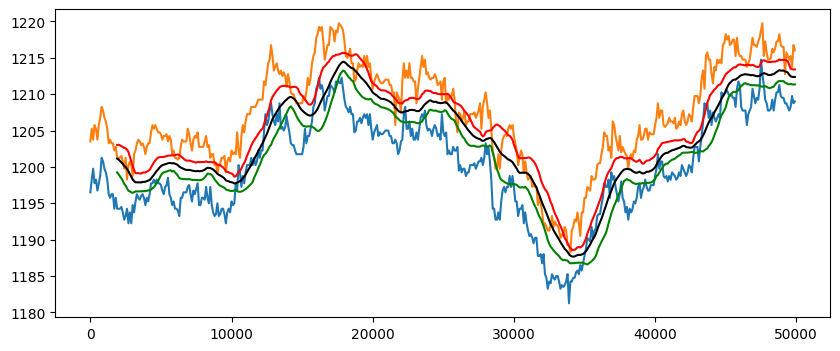

In [239]:
w_roll = 20
std_mul = 1

bid = prices_1['bid_price']
ask = prices_1['ask_price']
thr_h = prices_1['ORCHIDS'].rolling(w_roll).mean() + std_mul * prices_1['ORCHIDS'].rolling(w_roll).std()
thr_l = prices_1['ORCHIDS'].rolling(w_roll).mean() - std_mul * prices_1['ORCHIDS'].rolling(w_roll).std()
thr_mid = (thr_h + thr_l) / 2

plt.figure(figsize=(10, 4))
plt.plot(bid.iloc[:500])
plt.plot(ask.iloc[:500])
plt.plot(thr_h.iloc[:500], c='r')
plt.plot(thr_l.iloc[:500], c='g')
plt.plot(thr_mid.iloc[:500], c='k')
plt.show()

In [270]:
def calc_pnl(data, w_roll = 10, std_mul = 0):
    max_position = 100
    
    df = data.copy()
    df = df.assign(thr_h=lambda x: x['ORCHIDS'].rolling(w_roll).mean() + std_mul * x['ORCHIDS'].rolling(w_roll).std())
    df = df.assign(thr_l=lambda x: x['ORCHIDS'].rolling(w_roll).mean() - std_mul * x['ORCHIDS'].rolling(w_roll).std())
    df = df.assign(thr_m=lambda x: (x['thr_h'] + x['thr_l']) / 2)
    
    curr_position = 0
    pnl = 0
    traded_price = 0
    for idx, row in df.iterrows():
        if (curr_position == 0) and (row['ask_price'] <= row['thr_l']):
            curr_position = max_position
            traded_price = row['ask_price']
        if (curr_position == 0) and (row['bid_price'] >= row['thr_h']):
            curr_position = max_position
            traded_price = row['bid_price']
        if (curr_position < 0) and (row['ask_price'] <= row['thr_m']):
            pnl += (row['ask_price'] - traded_price) * curr_position
            curr_position = 0
            traded_price = 0
        if (curr_position > 0) and (row['bid_price'] >= row['thr_m']):
            pnl += (row['bid_price'] - traded_price) * curr_position
            curr_position = 0
            traded_price = 0
    return pnl

In [271]:
def calc_test_pnl(w_roll, std_mul):
    return (calc_pnl(prices_2, w_roll, std_mul) + calc_pnl(prices_3, w_roll, std_mul)) / 2

In [272]:
calc_pnl(prices_1, w_roll = 2, std_mul = 0.1), calc_pnl(prices_2, w_roll = 2, std_mul = 0.1), calc_pnl(prices_3, w_roll = 2, std_mul = 0.1)

(1750.0, 0, 350.0)

# Price prediction

In [365]:
model = LinearRegression()
model.fit(prices_1[['TRANSPORT_FEES', 'EXPORT_TARIFF', 'IMPORT_TARIFF', 'SUNLIGHT', 'HUMIDITY', 'ORCHIDS']].iloc[:-1].to_numpy(),
          prices_1['ORCHIDS'].iloc[1:].to_numpy())

y_pred = model.predict(prices_1[['TRANSPORT_FEES', 'EXPORT_TARIFF', 'IMPORT_TARIFF', 'SUNLIGHT', 'HUMIDITY', 'ORCHIDS']].iloc[:-1].to_numpy())
rmse = root_mean_squared_error(prices_1['ORCHIDS'].iloc[1:].to_numpy(), y_pred)
print(rmse)

y_pred = model.predict(prices_2[['TRANSPORT_FEES', 'EXPORT_TARIFF', 'IMPORT_TARIFF', 'SUNLIGHT', 'HUMIDITY', 'ORCHIDS']].iloc[:-1].to_numpy())
rmse = root_mean_squared_error(prices_2['ORCHIDS'].iloc[1:].to_numpy(), y_pred)
print(rmse)

y_pred = model.predict(prices_3[['TRANSPORT_FEES', 'EXPORT_TARIFF', 'IMPORT_TARIFF', 'SUNLIGHT', 'HUMIDITY', 'ORCHIDS']].iloc[:-1].to_numpy())
rmse = root_mean_squared_error(prices_3['ORCHIDS'].iloc[1:].to_numpy(), y_pred)
print(rmse)

0.9774336554867427
1.0436511395435097
1.1200677536772587


In [366]:
model = LinearRegression()
model.fit(prices_2[['TRANSPORT_FEES', 'EXPORT_TARIFF', 'IMPORT_TARIFF', 'SUNLIGHT', 'HUMIDITY', 'ORCHIDS']].iloc[:-1].to_numpy(),
          prices_2['ORCHIDS'].iloc[1:].to_numpy())

y_pred = model.predict(prices_1[['TRANSPORT_FEES', 'EXPORT_TARIFF', 'IMPORT_TARIFF', 'SUNLIGHT', 'HUMIDITY', 'ORCHIDS']].iloc[:-1].to_numpy())
rmse = root_mean_squared_error(prices_1['ORCHIDS'].iloc[1:].to_numpy(), y_pred)
print(rmse)

y_pred = model.predict(prices_2[['TRANSPORT_FEES', 'EXPORT_TARIFF', 'IMPORT_TARIFF', 'SUNLIGHT', 'HUMIDITY', 'ORCHIDS']].iloc[:-1].to_numpy())
rmse = root_mean_squared_error(prices_2['ORCHIDS'].iloc[1:].to_numpy(), y_pred)
print(rmse)

y_pred = model.predict(prices_3[['TRANSPORT_FEES', 'EXPORT_TARIFF', 'IMPORT_TARIFF', 'SUNLIGHT', 'HUMIDITY', 'ORCHIDS']].iloc[:-1].to_numpy())
rmse = root_mean_squared_error(prices_3['ORCHIDS'].iloc[1:].to_numpy(), y_pred)
print(rmse)

1.008855672924663
0.9976754382355102
1.103796244081811


In [368]:
model = LinearRegression()
model.fit(prices_3[['TRANSPORT_FEES', 'EXPORT_TARIFF', 'IMPORT_TARIFF', 'SUNLIGHT', 'HUMIDITY', 'ORCHIDS']].iloc[:-1].to_numpy(),
          prices_3['ORCHIDS'].iloc[1:].to_numpy())

y_pred = model.predict(prices_1[['TRANSPORT_FEES', 'EXPORT_TARIFF', 'IMPORT_TARIFF', 'SUNLIGHT', 'HUMIDITY', 'ORCHIDS']].iloc[:-1].to_numpy())
rmse = root_mean_squared_error(prices_1['ORCHIDS'].iloc[1:].to_numpy(), y_pred)
print(rmse)

y_pred = model.predict(prices_2[['TRANSPORT_FEES', 'EXPORT_TARIFF', 'IMPORT_TARIFF', 'SUNLIGHT', 'HUMIDITY', 'ORCHIDS']].iloc[:-1].to_numpy())
rmse = root_mean_squared_error(prices_2['ORCHIDS'].iloc[1:].to_numpy(), y_pred)
print(rmse)

y_pred = model.predict(prices_3[['TRANSPORT_FEES', 'EXPORT_TARIFF', 'IMPORT_TARIFF', 'SUNLIGHT', 'HUMIDITY', 'ORCHIDS']].iloc[:-1].to_numpy())
rmse = root_mean_squared_error(prices_3['ORCHIDS'].iloc[1:].to_numpy(), y_pred)
print(rmse)

0.9984532884477182
1.0033209736060467
1.1008356997073925


In [369]:
model.coef_

array([ 1.56943333e-01, -1.85791023e-02, -1.35174648e-02,  4.90294647e-06,
        2.68553807e-03,  9.98372618e-01])

In [370]:
model.intercept_

1.4561680433059792

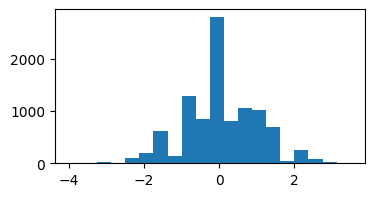

In [23]:
plt.figure(figsize=(4, 2))
plt.hist(prices_1['ORCHIDS'].diff().dropna(), bins=20)
plt.show()

In [22]:
((prices_1['ORCHIDS'].diff().dropna() ** 2).mean() ** (0.5), (prices_2['ORCHIDS'].diff().dropna() ** 2).mean() ** (0.5),
(prices_3['ORCHIDS'].diff().dropna() ** 2).mean() ** (0.5))

(0.9781743198428386, 0.9986616043485401, 1.101578413005629)

Naive assumption performs better

# Supply calculation

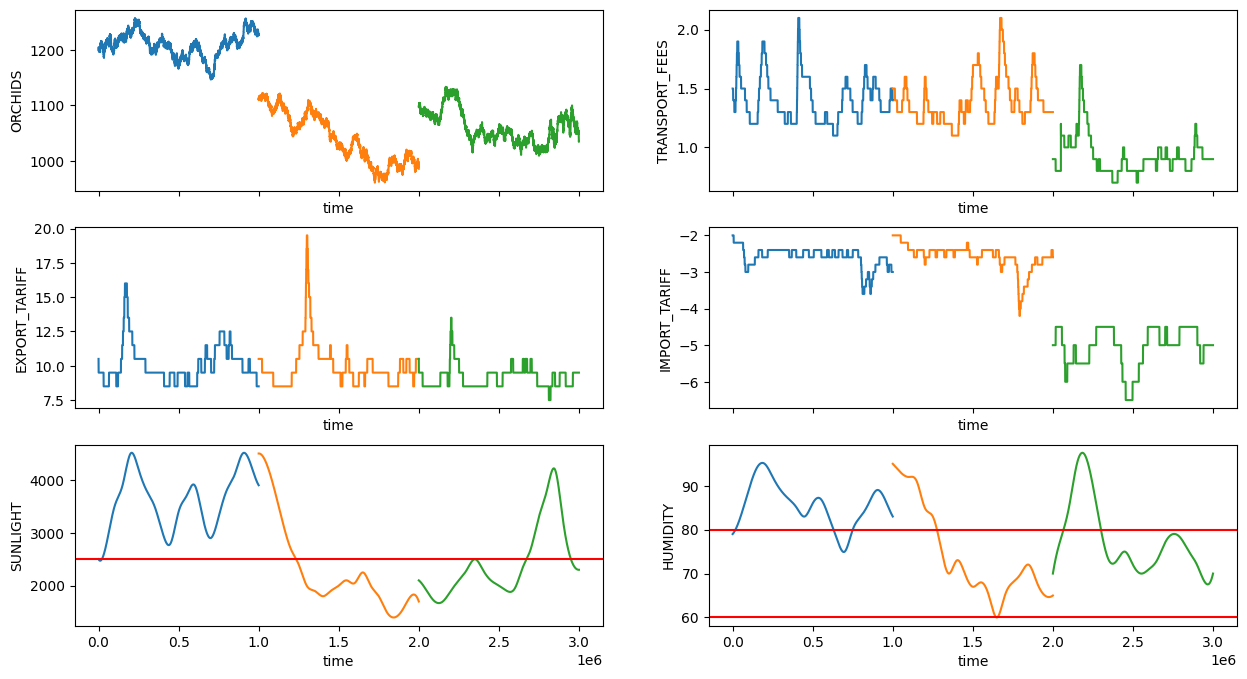

In [314]:
idx = np.array(prices_1.index)
fig, ax = plt.subplots(3, 2, figsize=(15, 8), sharex=True)
for i, col in enumerate(prices_1.columns[:-2]):
    ax[i // 2, i % 2].plot(idx, prices_1[col])
    ax[i // 2, i % 2].plot(idx + idx[-1], prices_2[col])
    ax[i // 2, i % 2].plot(idx + 2 * idx[-1], prices_3[col])
    ax[i // 2, i % 2].set_xlabel('time')
    ax[i // 2, i % 2].set_ylabel(col)
    if i == 4:
        ax[i // 2, i % 2].axhline(2500, c='r')
    if i == 5:
        ax[i // 2, i % 2].axhline(60, c='r')
        ax[i // 2, i % 2].axhline(80, c='r')
plt.show()

In [77]:
hours_per_day = 12
timestamps_per_7hours = int(prices_1.index[-1] / hours_per_day * 7 // 100 * 100)
timestamps_per_7hours
timestamps_per_hour = int(prices_1.index[-1] / hours_per_day // 100 * 100)
timestamps_per_hour
timestamps_per_10m = int(prices_1.index[-1] / hours_per_day / 6 // 100 * 100)
timestamps_per_10m
print(timestamps_per_7hours, timestamps_per_hour, timestamps_per_10m)

583300 83300 13800


In [79]:
prices_1['sun_roll'] = prices_1['SUNLIGHT'].cumsum()
w = prices_1.loc[:timestamps_per_7hours].shape[0]
prices_1.loc[timestamps_per_7hours:, 'sun_roll'] = prices_1['SUNLIGHT'].rolling(w).sum().dropna()

In [80]:
prices_2['sun_roll'] = prices_2['SUNLIGHT'].cumsum()
w = prices_2.loc[:timestamps_per_7hours].shape[0]
prices_2.loc[timestamps_per_7hours:, 'sun_roll'] = prices_2['SUNLIGHT'].rolling(w).sum().dropna()

In [86]:
prices_3['sun_roll'] = prices_3['SUNLIGHT'].cumsum()
w = prices_3.loc[:timestamps_per_7hours].shape[0]
prices_3.loc[timestamps_per_7hours:, 'sun_roll'] = prices_3['SUNLIGHT'].rolling(w).sum().dropna()

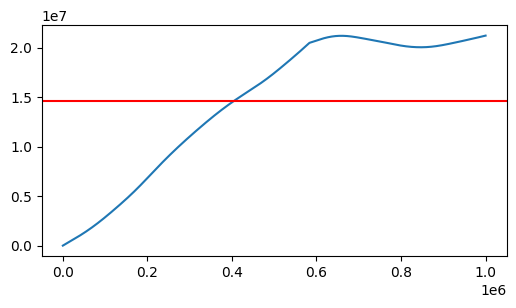

In [92]:
plt.figure(figsize=(6, 3))
plt.plot(prices_1['sun_roll'])
plt.axhline(2500 * timestamps_per_7hours//100, c='r')
plt.show()

In [93]:
thr = 2500 * timestamps_per_7hours // 100
dif = 2500 * timestamps_per_10m // 100
def sun_effect(sun, thr=thr, dif=dif):
    if sun < thr:
        return 0.96 ** ((thr - sun) // dif)
    else:
        return 1

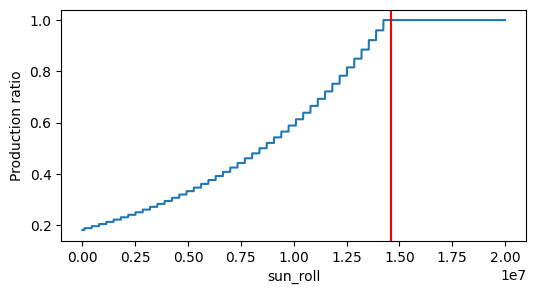

In [99]:
plt.figure(figsize=(6, 3))
plt.plot(range(100, int(2e7), 100), [sun_effect(s) for s in range(100, int(2e7), 100)])
plt.axvline(thr, c='r')
plt.xlabel('sun_roll')
plt.ylabel('Production ratio')
plt.show()

In [101]:
def humidity_effect(humidity, thr_l=60, thr_h=80):
    if humidity > thr_h:
        return 0.98 ** ((humidity - thr_h) // 5)
    elif humidity < thr_l:
        return 0.98 ** ((thr_l - humidity) // 5)
    else:
        return 1

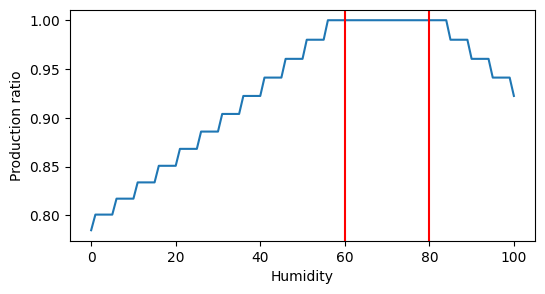

In [103]:
plt.figure(figsize=(6, 3))
plt.plot(range(0, 101, 1), [humidity_effect(hum) for hum in range(0, 101, 1)])
plt.axvline(60, c='r')
plt.axvline(80, c='r')
plt.xlabel('Humidity')
plt.ylabel('Production ratio')
plt.show()

In [105]:
thr_sun = thr
thr_hum_h = 80
thr_hum_l = 60

prices_1 = prices_1.assign(production_ratio=
                           lambda x: np.array([sun_effect(elem) for elem in x.sun_roll]) * np.array([humidity_effect(elem) for elem in x.HUMIDITY]))
prices_2 = prices_2.assign(production_ratio=
                           lambda x: np.array([sun_effect(elem) for elem in x.sun_roll]) * np.array([humidity_effect(elem) for elem in x.HUMIDITY]))
prices_3 = prices_3.assign(production_ratio=
                           lambda x: np.array([sun_effect(elem) for elem in x.sun_roll]) * np.array([humidity_effect(elem) for elem in x.HUMIDITY]))

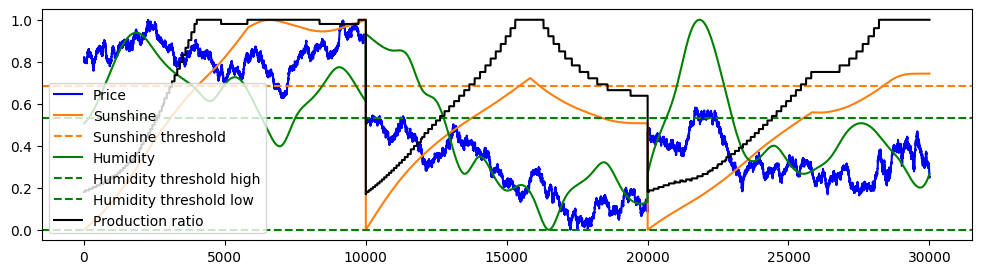

In [111]:
df = pd.concat([prices_1, prices_2, prices_3]).reset_index(drop=True)
price = df['ORCHIDS']
sun = df['SUNLIGHT']
sun_roll = sun = df['sun_roll']
hum = df['HUMIDITY']
prod = df['production_ratio']

plt.figure(figsize=(12, 3))
plt.plot((price - price.min()) / (price.max() - price.min()), label='Price', c='b')
plt.plot((sun - sun.min()) / (sun.max() - sun.min()), label='Sunshine', c='tab:orange')
plt.axhline((thr_sun - sun_roll.min()) / (sun_roll.max() - sun_roll.min()), c='tab:orange', linestyle='--', label='Sunshine threshold')
plt.plot((hum - hum.min()) / (hum.max() - hum.min()), label='Humidity', c='g')
plt.axhline((thr_hum_h - hum.min()) / (hum.max() - hum.min()), c='g', linestyle='--', label='Humidity threshold high')
plt.axhline((thr_hum_l - hum.min()) / (hum.max() - hum.min()), c='g', linestyle='--', label='Humidity threshold low')
plt.plot(prod, c='k', label='Production ratio')
plt.legend()
plt.show()

In [113]:
prices_1 = prices_1.drop(columns=['sun_roll'])
prices_2 = prices_2.drop(columns=['sun_roll'])
prices_3 = prices_3.drop(columns=['sun_roll'])

In [128]:
print((prices_1[['ORCHIDS', 'production_ratio']].corr().to_numpy()[0, 1],
prices_2[['ORCHIDS', 'production_ratio']].corr().to_numpy()[0, 1],
prices_3[['ORCHIDS', 'production_ratio']].corr().to_numpy()[0, 1]))

(-0.30462562537519244, -0.6570628057939009, -0.5447277027111088)


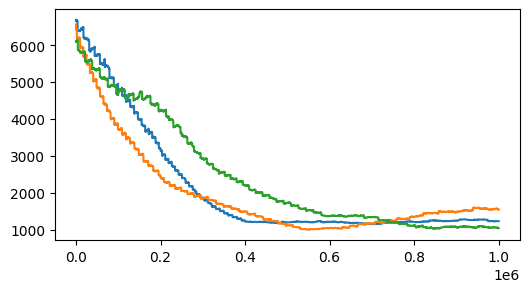

In [251]:
plt.figure(figsize=(6, 3))
plt.plot(prices_1['ORCHIDS'] / prices_1['production_ratio'])
plt.plot(prices_2['ORCHIDS'] / prices_2['production_ratio'])
plt.plot(prices_3['ORCHIDS'] / prices_3['production_ratio'])
plt.show()

# Demand modelling

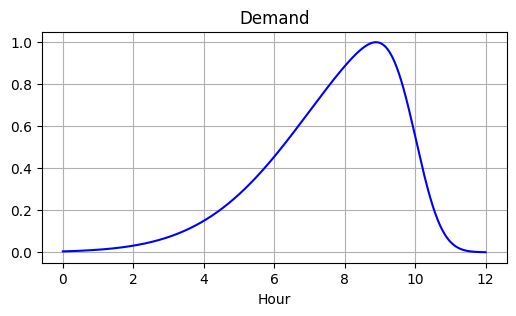

In [223]:
# Define parameters for the skewed right distribution
a = -5  # Skewness parameter
mean = 10  # Mean of the distribution
std_dev = 3  # Standard deviation of the distribution

# Generate data points
x = np.linspace(0, 12, prices_1.shape[0])
y = skewnorm.pdf(x, a, loc=mean, scale=std_dev)
y = y / y.max()

# Plot the skewed Gaussian-like function
plt.figure(figsize=(6, 3))
plt.plot(x, y, color='blue')
plt.title('Demand')
plt.xlabel('Hour')
plt.grid(True)
plt.show()

In [231]:
x = np.linspace(0, 12, prices_1.shape[0])

corrs = {}
for a in range(-10, 11):
    for mean in range(6, 12):
        for std_dev in range(1, 11):
            y = skewnorm.pdf(x, a, loc=mean, scale=std_dev)
            y = y / y.max()
            prices_1.loc[:, 'demand_ratio'] = y
            prices_2.loc[:, 'demand_ratio'] = y
            prices_3.loc[:, 'demand_ratio'] = y
            prices_1.loc[:, 'excess_supply'] = prices_1['production_ratio'] - prices_1['demand_ratio']
            prices_2.loc[:, 'excess_supply'] = prices_2['production_ratio'] - prices_2['demand_ratio']
            prices_3.loc[:, 'excess_supply'] = prices_3['production_ratio'] - prices_3['demand_ratio']
            corr = (prices_1[['ORCHIDS', 'excess_supply']].corr().to_numpy()[0, 1] +\
                    prices_2[['ORCHIDS', 'excess_supply']].corr().to_numpy()[0, 1] +\
                    prices_3[['ORCHIDS', 'excess_supply']].corr().to_numpy()[0, 1]) / 3
            corrs[(a, mean, std_dev)] = corr

In [237]:
[k for k, v in corrs.items() if v == min(list(corrs.values()))]

[(-8, 6, 10)]

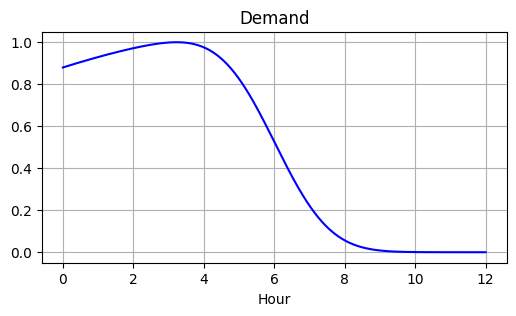

In [238]:
# Define parameters for the skewed right distribution
a = -8  # Skewness parameter
mean = 6  # Mean of the distribution
std_dev = 10  # Standard deviation of the distribution

# Generate data points
x = np.linspace(0, 12, prices_1.shape[0])
y = skewnorm.pdf(x, a, loc=mean, scale=std_dev)
y = y / y.max()

# Plot the skewed Gaussian-like function
plt.figure(figsize=(6, 3))
plt.plot(x, y, color='blue')
plt.title('Demand')
plt.xlabel('Hour')
plt.grid(True)
plt.show()

In [239]:
prices_1.loc[:, 'demand_ratio'] = y
prices_2.loc[:, 'demand_ratio'] = y
prices_3.loc[:, 'demand_ratio'] = y

In [240]:
prices_1.loc[:, 'excess_supply'] = prices_1['production_ratio'] - prices_1['demand_ratio']
prices_2.loc[:, 'excess_supply'] = prices_2['production_ratio'] - prices_2['demand_ratio']
prices_3.loc[:, 'excess_supply'] = prices_3['production_ratio'] - prices_3['demand_ratio']

In [241]:
prices_1['ORCHIDS'].mean(), prices_2['ORCHIDS'].mean(), prices_3['ORCHIDS'].mean()

(1208.8047445255474, 1041.2511748825118, 1060.7976452354765)

In [242]:
prices_1[prices_1['excess_supply'] < 0]['ORCHIDS'].mean(), prices_2[prices_2['excess_supply'] < 0]['ORCHIDS'].mean(), prices_3[prices_3['excess_supply'] < 0]['ORCHIDS'].mean()

(1217.86531898136, 1086.6719039888683, 1076.0303280379617)

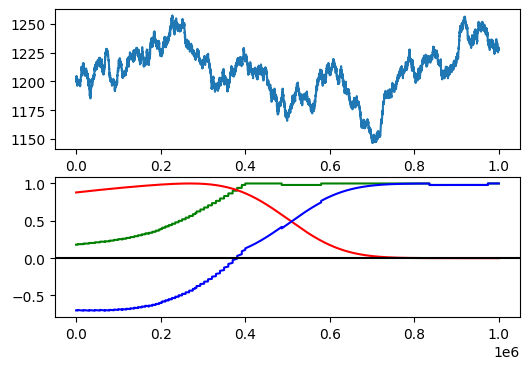

In [243]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4))
ax[0].plot(prices_1['ORCHIDS'])
ax[1].plot(prices_1['production_ratio'], c='g')
ax[1].plot(prices_1['demand_ratio'], c='r')
ax[1].plot(prices_1['excess_supply'], c='b')
ax[1].axhline(0, c='k')
plt.show()

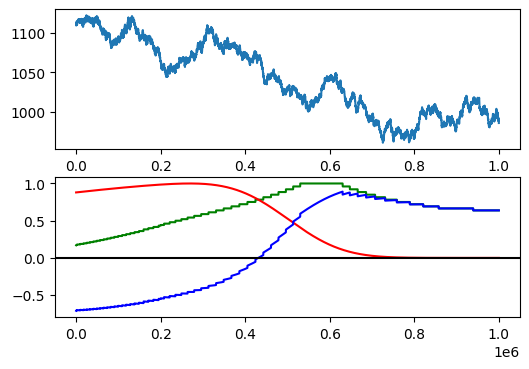

In [244]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4))
ax[0].plot(prices_2['ORCHIDS'])
ax[1].plot(prices_2['production_ratio'], c='g')
ax[1].plot(prices_2['demand_ratio'], c='r')
ax[1].plot(prices_2['excess_supply'], c='b')
ax[1].axhline(0, c='k')
plt.show()

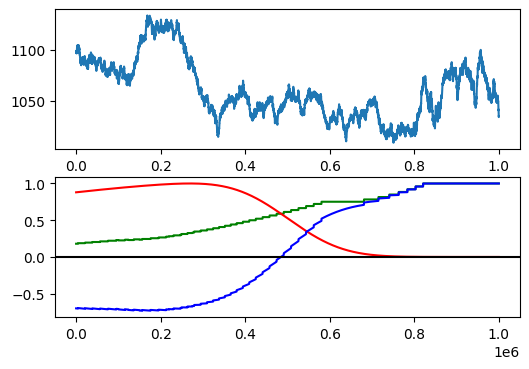

In [245]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4))
ax[0].plot(prices_3['ORCHIDS'])
ax[1].plot(prices_3['production_ratio'], c='g')
ax[1].plot(prices_3['demand_ratio'], c='r')
ax[1].plot(prices_3['excess_supply'], c='b')
ax[1].axhline(0, c='k')
plt.show()

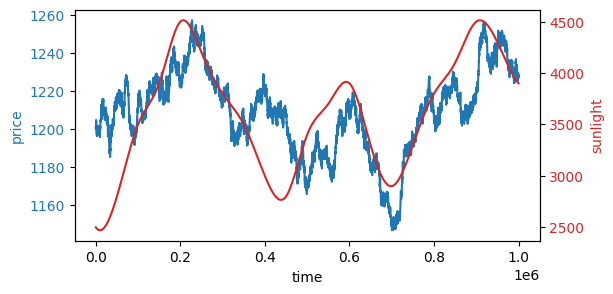

In [281]:
fig, ax1 = plt.subplots(figsize=(6, 3))
ax1.set_xlabel('time')
ax1.set_ylabel('price', color='tab:blue')
ax1.plot(prices_1['ORCHIDS'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('sunlight', color='tab:red')  # we already handled the x-label with ax1
ax2.plot(prices_1['SUNLIGHT'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.show()

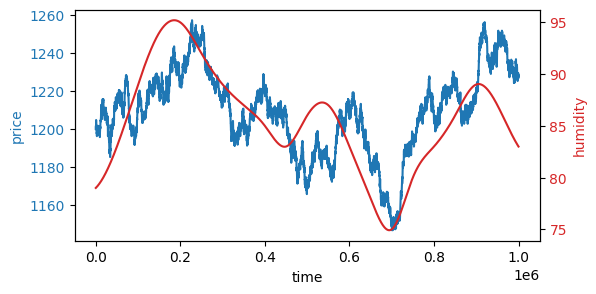

In [278]:
fig, ax1 = plt.subplots(figsize=(6, 3))
ax1.set_xlabel('time')
ax1.set_ylabel('price', color='tab:blue')
ax1.plot(prices_1['ORCHIDS'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('humidity', color='tab:red')  # we already handled the x-label with ax1
ax2.plot(prices_1['HUMIDITY'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.show()